**[PIL](https://pillow.readthedocs.io/en/latest/) Based Loader, Filter and Visualizer**

In [2]:
import sys
import os
from zipfile import ZipFile
import re

In [3]:
from PIL import \
    Image, ImageFilter

import numpy as np

import matplotlib.pyplot as plt
try:
    %matplotlib inline
    plot_ok = True
except (NameError) as e:
    print("{}: Running without plotting".format(e), file=sys.stderr)
    plot_ok = False

**Loader**

In [4]:
def pil_to_npa(pil_img, as_float=False):
    """Convert PIL image to numpy array
    """
    if pil_img.mode == 'L':
        npa_shape = pil_img.size
    elif pil_img.mode == 'RGB':
        npa_shape = (pil_img.height, pil_img.width, 3)
    elif pil_img.mode == 'RGBA':
        npa_shape = (pil_img.height, pil_img.width, 4)
    elif pil_img.mode in ['CMYK']:
        return pil_to_npa(pil_img.convert('RGB'))
    else:
        raise RuntimeError("{}: Invalid PIL mode".format(pil_img.mode))
    npa = np.array(pil_img.getdata(), dtype=np.uint8).reshape(*npa_shape)
    if as_float:
        npa = (npa / 255).astype(IMG_FLOAT_TYPE)
    return npa

def npa_to_pil(npa):
    """Convert numpy array to PIL image
    """
    if npa.dtype in [np.float16, np.float32, np.float64]:
        npa = (npa * 255).astype(np.uint8)
    return Image.fromarray(npa)

def load_image(img_file, as_float=False):
    """Load image file (path or object)
    """
    if hasattr(img_file, 'read'):
        pil_img = Image.open(img_file)
    else:
         with open(img_file, 'rb') as f:
            pil_img = Image.open(f)
            pil_img.load()
    return pil_to_npa(pil_img, as_float=as_float)

def load_zip_archive(archive_file, 
                     file_list=None, 
                     suffix_list=['jpeg', 'jpg', 'png'],
                     as_float=False):
    """Load (selected) image(s) from zip archive file
    """
    if type(file_list) in [str]:
        file_list = [file_list]

    if type(suffix_list) in [str]:
        suffix_list = [suffix_list]
    if suffix_list and type(suffix_list) not in [set]:
        suffix_list = set(suffix_list)

    imgs = []
    with ZipFile(archive_file, 'r') as zfa:
        for f_info in zfa.infolist():
            if f_info.is_dir():
                continue

            if suffix_list:
                i = f_info.filename.rfind('.')
                suffix = f_info.filename[i+1:].lower() if i >= 0 else ''
                if suffix not in suffix_list:
                    continue

            if file_list:
                use_f = False
                for fl in file_list:
                    if re.match(fl, f_info.filename):
                        use_f = True
                        break
                if not use_f:
                    continue

            imgs.append((load_image(zfa.open(f_info)), f_info.filename))
    return imgs

**Visualizer**

In [5]:
GRAY_SCALE_CMAP = plt.get_cmap('gray')

DEFAULT_SIZE = None
IMG_FLOAT_TYPE = np.float16

def plot_image(img, title=None, ax=None, size=DEFAULT_SIZE, interpolation=None):
    if not plot_ok:
        return
    if ax is None:
        if size:
            height, width = img.shape[:2]
            m = max(height, width)
            figsize = width*size//m, height*size//m
            fig = plt.figure(figsize=figsize)
        else:
            fig = plt.figure()
        ax = plt.gca()
    if img.dtype == np.float16:
        img = img.astype(np.float32)
    vmax = 1 if img.dtype in [np.float32, np.float64] \
        else 255
    #ax.set_xticks([])
    #ax.set_yticks([])
    if title is not None:
        ax.set_title(title, loc='left')
    ax.imshow(img, aspect='equal', vmin=0, vmax=vmax, 
              interpolation=interpolation,
              cmap=GRAY_SCALE_CMAP if len(img.shape) == 2 else None)

**Filters**

In [6]:
def apply_pil_filter(img, pil_filter):
    pil_img = npa_to_pil(img)
    return pil_to_npa(pil_img.filter(pil_filter))

def gaussian_blur_filter(img, radius=2):
    return apply_pil_filter(img, ImageFilter.GaussianBlur(radius=radius))

def unsharpen_mask_filter(img, radius=2, percent=150, threshold=3):
    return apply_pil_filter(img, ImageFilter.UnsharpMask(radius=radius, 
                                                     percent=percent, 
                                                     threshold=threshold))

def kernel_filter(img, size, kernel, scale=None, offset=0):
    return apply_pil_filter(img, ImageFilter.Kernel(size,
                                                kernel,
                                                scale=scale,
                                                offset=offset))

def rank_filter(img, size=3, rank=1):
    return apply_pil_filter(img, ImageFilter.RankFilter(size=size, rank=rank))

def median_filter(img, size=3):
    return apply_pil_filter(img, ImageFilter.MedianFilter(size=size))

def min_filter(img, size=3):
    return apply_pil_filter(img, ImageFilter.MinFilter(size=size))

def max_filter(img, size=3):
    return apply_pil_filter(img, ImageFilter.MaxFilter(size=size))

def mode_filter(img, size=3):
    return apply_pil_filter(img, ImageFilter.ModeFilter(size=size))

def blur_filter(img):
    return apply_pil_filter(img, ImageFilter.BLUR)

def contour_filter(img):
    return apply_pil_filter(img, ImageFilter.CONTOUR)

def detail_filter(img):
    return apply_pil_filter(img, ImageFilter.DETAIL)

def edge_enahnce_filter(img):
    return apply_pil_filter(img, ImageFilter.EDGE_ENHANCE)

def edge_enahnce_more_filter(img):
    return apply_pil_filter(img, ImageFilter.EDGE_ENHANCE_MORE)

def emboss_filter(img):
    return apply_pil_filter(img, ImageFilter.EMBOSS)

def find_edges_filter(img):
    return apply_pil_filter(img, ImageFilter.FIND_EDGES)

def sharpen_filter(img):
    return apply_pil_filter(img, ImageFilter.SHARPEN)

def smooth_filter(img):
    return apply_pil_filter(img, ImageFilter.SMOOTH)

def smooth_more_filter(img):
    return apply_pil_filter(img, ImageFilter.SMOOTH_MORE)

**Test**

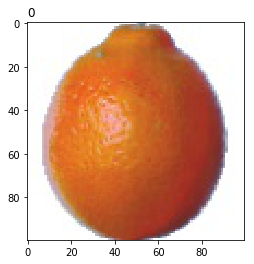

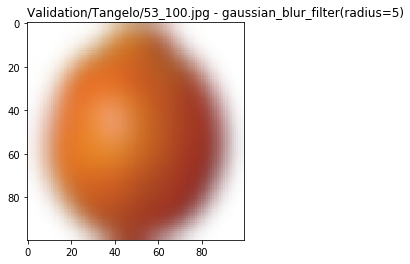

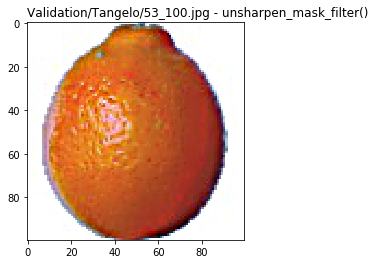

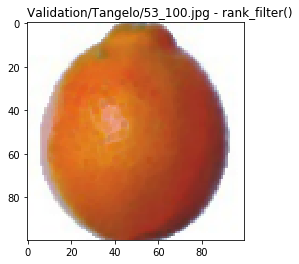

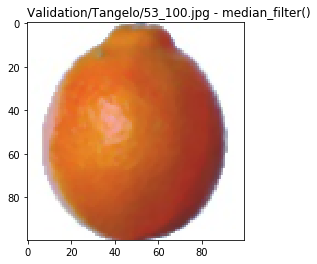

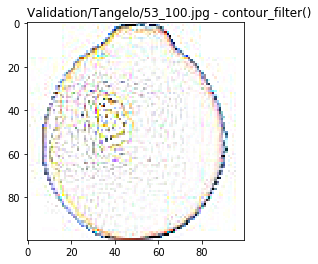

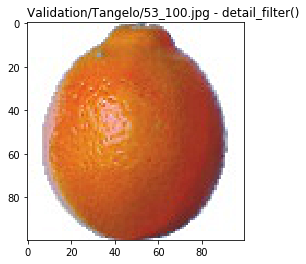

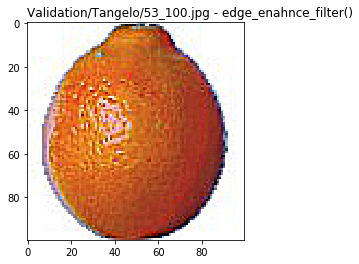

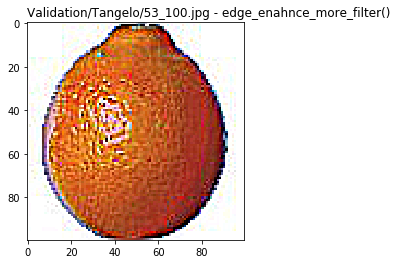

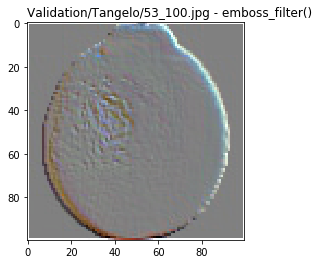

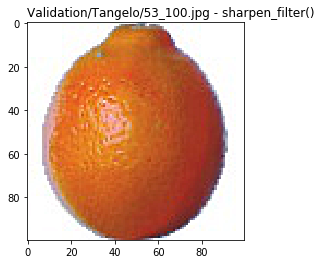

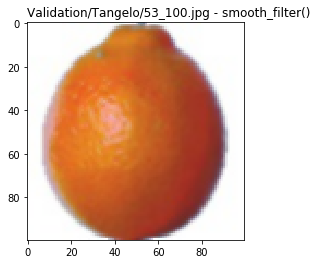

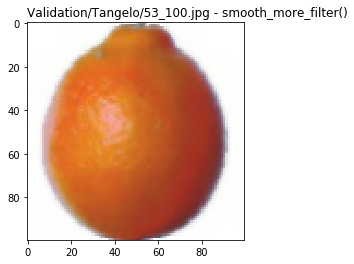

In [7]:
if __name__ == '__main__':
    #img = load_image('data/fruits-360/Training/Apple Braeburn/1_100.jpg')
    #img = load_image('data/western878.png')
    #imgs = load_zip_archive('data/interiors/validation.zip', 
    #                        file_list='validation/preppy757.png')
    imgs = load_zip_archive('data/fruits-360/validation.zip',
                            file_list='Validation/Tangelo/53_100.jpg')
    img, img_name = imgs[0]    
    plot_image(img, title='{} - original'.format(img_name)) #, interpolation='bilinear')
    
    for filter_func_args in [
        (gaussian_blur_filter, dict(radius=5)),
        unsharpen_mask_filter,
        rank_filter,
        median_filter,
        contour_filter,
        detail_filter,
        edge_enahnce_filter,
        edge_enahnce_more_filter,
        emboss_filter,
        sharpen_filter,
        smooth_filter,
        smooth_more_filter
    ]:
        if type(filter_func_args) in [list, tuple]:
            filter_func, filter_args = filter_func_args[0], filter_func_args[1]
        else:
            filter_func, filter_args = filter_func_args, {}
        args = ''
        for k, v in sorted(filter_args.items()):
            if args:
                args += ', '
            args += '{}={!r}'.format(k, v)
        plot_image(filter_func(img, **filter_args), 
                   title='{} - {}({})'.format(img_name, filter_func.__name__, args))